In [188]:
# setup
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import zipfile
from tqdm import tqdm

# Random generator
rng1 = np.random.RandomState(seed=123)

In [189]:
train_df_ori = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df_ori = pd.read_csv('/kaggle/input/titanic/test.csv')

train_df = train_df_ori.copy()
test_df = test_df_ori.copy()

In [190]:
display(train_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [191]:
irrelevant_feats = ['PassengerId', 'Name']
train_df.drop(irrelevant_feats, axis=1, inplace=True)
test_df.drop(irrelevant_feats, axis=1, inplace=True)


In [192]:
missing_too_many = ['Cabin', 'Ticket']
train_df.drop(missing_too_many, axis=1, inplace=True)
test_df.drop(missing_too_many, axis=1, inplace=True)

In [193]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median') 
age_fill = imputer.fit_transform(train_df['Age'].values.reshape(-1,1))
train_df['Age'] = age_fill
age_fill = imputer.transform(test_df['Age'].values.reshape(-1,1))
test_df['Age'] = age_fill

In [194]:
display(test_df.head())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [195]:
def dataframe_onehotencoder(encoder, df, columns_names, fit_transform=True):
    '''
    This is a helper function to apply sklearn onehotencoder function
    on multiple columns of a data frame.

    Args:
        encoder: initialized OneHotEncoder
        df: Pandas dataframe with data
        columns_names: names of the columns in dataframe to encode
        fit_transform: True when the encoder is seeing the categorical data for the first time; False otherwise.
    
    Returns:
        dataframe: with one-hot-encoded columns
    '''
    
    # One-hot-encode the columns in column names
    if(fit_transform):
        data = encoder.fit_transform(df[columns_names])
    else:
        data = encoder.transform(df[columns_names])

    # Convert data to a dataframe
    df2 = pd.DataFrame(data, columns=encoder.get_feature_names_out(columns_names), index=df.index)
    
    # Recreate original dataframe
    df3 = pd.concat([df.drop(columns_names, axis=1), df2], axis=1)
    
    # Return
    return df3 

In [196]:
columns_to_encode = ['Sex', 'Embarked']
encoder = OneHotEncoder(drop='first', sparse_output=False) # drops first feature to avoid colinear features
df_OHE = dataframe_onehotencoder(encoder=encoder, df=train_df, columns_names=columns_to_encode, fit_transform=True)
df_test_OHE = dataframe_onehotencoder(encoder=encoder, df=test_df, columns_names=columns_to_encode, fit_transform=True)
display(df_test_OHE.head())

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,1.0,1.0,0.0
1,3,47.0,1,0,7.0000,0.0,0.0,1.0
2,2,62.0,0,0,9.6875,1.0,1.0,0.0
3,3,27.0,0,0,8.6625,1.0,0.0,1.0
4,3,22.0,1,1,12.2875,0.0,0.0,1.0


In [197]:
def dataframe_normalization(transformer, df, fit_transform=True):
    '''
    This is a helper function to normalize the dataset features using the ColumnTransformer class.

    Args:
        transformer: initialized ColumnTransformer
        df: Pandas dataframe with the data
        fit_transform: True when the transformer is seeing the data for the first time; False otherwise.
    
    Returns:
        dataframe: with specific normalized columns
    '''
    
    # Copy data
    df2 = df.copy()

    if(fit_transform):
        data = transformer.fit_transform(df2)
    else:
        data = transformer.transform(df2)

    # Add normalized data to dataframe
    for index, column in enumerate(transformer.get_feature_names_out()):
        df2[column] = data[:,index]
        
    # Return
    return df2 

In [198]:
# Using ColumnTransformer to apply specific normalization to each column in our data
norm_scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), ['Pclass', 'Parch']),  
        ('standard', StandardScaler(), ['Age', 'SibSp', 'Fare'])
    ], verbose_feature_names_out=False
)

# Normalize data (Treat all features the same)
train_df2 = dataframe_normalization(transformer=norm_scaler, df=df_OHE, fit_transform=True)
test_df2 = dataframe_normalization(transformer=norm_scaler, df=df_test_OHE, fit_transform=True)

In [212]:
train_df2.drop(['Embarked_nan'], axis=1, inplace=True)

y = train_df2['Survived'].values
X = train_df2.iloc[:,1:].values

In [213]:
X, X_val, y, y_val = train_test_split(X, y, test_size=0.15, random_state=rng1, stratify=y)
def sigmoid(z):
    z = np.asarray(z, dtype=np.float64)
    return (1/(1 + np.exp(-z)))

def initialize_params(m_features, seed=None):
    w = seed.normal(loc=0.0, scale=1, size=m_features)
    b = np.float64(0.0)
    return w, b

def forward(X,w,b):
    z = X.dot(w) + b
    y_hat = sigmoid(z)
    return z, y_hat

def compute_cost(y,y_hat):
    loss_vector = -(y * (np.log(y_hat)) + (1-y) * (np.log(1-y_hat)))
    return loss_vector.mean()

def compute_gradients(X, y, y_hat):
    n = X.shape[0]
    dw = ((X.T).dot(y_hat-y))/n
    db = (y_hat-y).mean()
    return dw, db

def update_params(w, b, dw, db, lr):
    w = w - (lr * dw)
    b = b - (lr * db)
    return w, b

def train(X, y, lr, n_epochs, X_val=None, y_val=None):
    n, m = X.shape
    w, b = initialize_params(m, rng1)
    history = {"train": [], "val": []}
    
    for epochs in range(n_epochs):
        _, y_hat = forward(X, w, b)
        history["train"].append(compute_cost(y, y_hat))
        dw, db = compute_gradients(X, y, y_hat)
        _, yv_hat = forward(X_val, w, b)
        history["val"].append(compute_cost(y_val, yv_hat))
        
        w, b = update_params(w, b, dw, db, lr)
        
        
    return w, b, history

def predict_proba(X, w, b):
    _, y_hat = forward(X, w, b)
    return y_hat

In [300]:
w, b, history = train(X,y,3.5,30,X_val,y_val)

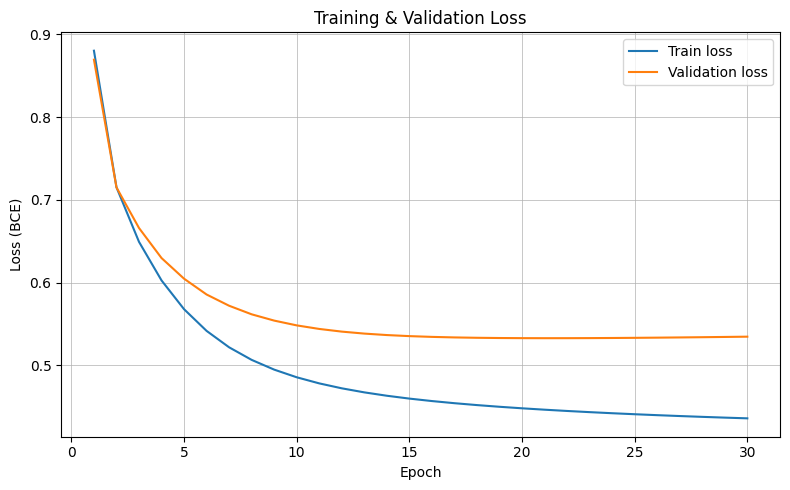

In [301]:
epochs = range(1, len(history['train']) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, history['train'], label='Train loss')
plt.plot(epochs, history['val'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()

In [306]:
survival_rate = ((predict_proba(X_val,w,b).round() == 1).sum())/(y_val == 1).sum()
print(f"{survival_rate * 100}% Accurate")

84.31372549019608% Accurate


In [312]:
X_test = test_df2.iloc[:,0:].values
feature_cols = list(test_df2.columns[0:])
passenger_ids = test_df_ori["PassengerId"].to_numpy(dtype=int)

predictions = predict_proba(X_test, w, b).round()
np.nan_to_num(predictions, nan=0.0, copy=False)  
y_pred = predictions.astype(int)
sub = np.column_stack((passenger_ids, y_pred))
np.savetxt(
    "submission.csv",
    sub,
    fmt="%d",                          
    delimiter=",",
    header="PassengerId,Survived",
    comments=""                              
)